Modeling Temperature based off greenhouse gases


We have scraping code to get all the needed data, but not included in here as there was parsing afterwards to make sure the data was correct.  We scraped two websites to get CH4, and CO2.  The greenhouse gases were from ESLR and the weather data is from kaggle.  

This is the world controller class.  Here we mainly aggregate weather data to be used within this class.

In [1]:
from datetime import datetime
import pandas as pd
import glob
import numpy as np
from matplotlib import pyplot
#change this class to contioulsy run in future.

##MAIN##

## CREATE/PARSE DATA FOR ML MODEL##


##CREATE OBJECTS FOR EACH CITY##
## City obj will handle data passed in through none statements
#CountryObj() # only do UNITED STATES
class WorldController:
    def __init__(self, oo = False):
        if oo:
            cityCountryDict = {}
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt', infer_datetime_format=True)
                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States' ]

                weatherGroup = weatherCityData.groupby(['Longitude', 'Latitude'])

                for  key, item in weatherGroup:
                    for city in item.City.unique():
                        cityCountryDict[city]   =  {'Location': [*item.Longitude.unique(), *item.Latitude.unique()]}
                # remove break

            allWeatherCityData = pd.DataFrame()
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt')

                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States']
                weatherCityData.index = pd.to_datetime(weatherCityData.index)
                weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
                weatherCityData = weatherCityData[weatherCityData.index.year <= 2012]
                allWeatherCityData = allWeatherCityData.append(weatherCityData)
                for key in cityCountryDict.keys():
                    #pd.DataFrame(weatherCityData['AverageTemperature'].resample('W').sum(), columns=['AverageTemperature'])
                    weatherDict = weatherCityData[weatherCityData['City'] == key]['AverageTemperature']
                    i = 0
                    cityCountryDict[key]['time'] = []
                    for date in weatherDict.index.to_pydatetime():
                        otherDict = {date.strftime("%Y-%m-%d"): weatherDict.values[i]}
                        cityCountryDict[key]['time'].append(otherDict)
                        i+=1
                # remove break

            #cityCountryDict has City as key, Location : [longitude, latitude], time: [{WEEK TIMESTAMP : weather}...*]. Each child will find data to fit with its parent classes to pass data to it.  (read the csv, etc.)
            allStateData = pd.read_csv('./data/weather/GlobalLandTemperaturesByState.csv')
            allStateData = allStateData[allStateData['Country'] =='United States']
            allStateData.dt = pd.to_datetime(allStateData.dt)
            allStateData = allStateData.set_index(drop=True, keys='dt')

            #get weather data from 1960 and above.
            allStateData = allStateData[allStateData.index.year>=1960]#.resample('W').mean()['AverageTemperature']
            allStateData = allStateData[allStateData.index.year<2012]
            allStates = []
            for state in allStateData['State'].unique():
                otherData = allStateData[allStateData['State'] == state]
                allStates.append(StateObj(state, otherData))


            for city in cityCountryDict.keys():
                cityStateName = findState(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1])
                for state in allStates:
                    if cityStateName == state.getStateName():
                        state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                        #need this break.  Found the state.
                        break
                    if cityStateName == 'StateNA':
                        state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                        break


            # this is only class attribute that will be used
            self.states = allStates
            self.longLat = weatherCityData


        else:
            weatherCityData = pd.read_csv('./data/weather/unitedStatesTemp.csv', header=0, index_col='dt')
            weatherCityData.index = pd.to_datetime(weatherCityData.index)
            weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
            weatherCityData = weatherCityData[weatherCityData.index.year <= 2012]
            weatherCityData.Latitude = weatherCityData.Latitude.apply(parseLat)
            weatherCityData.Longitude = weatherCityData.Longitude.apply(parseLong)

            self.monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for name, group in weatherCityData.groupby(by=[weatherCityData.index.month]):

                self.monthDict[group.index[0].month] = group
            #print (monthDict)
            averageMonthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for dataFrame in self.monthDict.keys():
                averageMonthDict[dataFrame] = self.monthDict[dataFrame].groupby(by=self.monthDict[dataFrame].index).agg('mean')['AverageTemperature']
            #monthDict[1].to_csv('month1 temperatures')
            self.graphMonthlyChange(averageMonthDict)
            #self.calculatePerIncrease(averageMonthDict)

        




    def calculatePerIncrease(self, aDict):
        for key in aDict.keys():
            print('%increase for month {}  == {}'.format(key, ((aDict[key][-1] - aDict[key][0])/aDict[key][0])*100 ) )


    def graphMonthlyChange(self, aDict):
        for key in aDict.keys():
            pyplot.plot(aDict[key], label=key)
        #pyplot.plot(graphed)
        pyplot.xlabel('Years')
        pyplot.ylabel('Temperature in Celsius')
        pyplot.legend()
        pyplot.savefig('./generatedData/monthDataWithlegend')

        pyplot.figure().clear()

    def getDfToTrain(self,sf6, n2o, co2, ch4, removeIndex=True):
        sf6 = self.createMonthYear(sf6)
        n2o = self.createMonthYear(n2o)
        co2 = self.createMonthYear(co2)
        ch4 = self.createMonthYear(ch4)
        dfMonthArray = []
        for keys in self.monthDict:
            month1 = pd.DataFrame(self.monthDict[keys][['AverageTemperature', 'Latitude', 'Longitude']])
            month1['sf6'] = np.nan
            month1['n2o'] = np.nan
            month1['co2'] = np.nan
            month1['ch4'] = np.nan
            monthParsed = month1.reset_index()
            i =0
            for index, row in monthParsed.iterrows():
                #print(sf6.loc[index.date()].values[0])
                ymRow = "{}/{}".format(row['dt'].year, row['dt'].month)
                month1['sf6'].iloc[i] = sf6[sf6['index'] == ymRow]['average'].values[0]
                month1['n2o'].iloc[i] = n2o[n2o['index'] == ymRow]['average'].values[0]
                month1['co2'].iloc[i] = co2[co2['index'] == ymRow]['CarbonEmissions'].values[0]
                month1['ch4'].iloc[i] = ch4[ch4['index'] == ymRow]['average'].values[0]
                i+=1
            if removeIndex:
                month1.reset_index(drop=True, inplace=True)
            else:
                month1.reset_index(drop=False, inplace=True)
            dfMonthArray.append(month1)
        return dfMonthArray

    


    
    def getMonthDict(self):
        return self.monthDict
    
    def createMonthYear(self, df):
        sf6YearMonth = []
        for i in range(0, len(df.index.year)):
            sf6YearMonth.append('{}/{}'.format(df.index[i].year, df.index[i].month ))
        df = df.reset_index()
        df['index'] = pd.Series(sf6YearMonth)
        return df

    def train_state_models(self):
        stateModel = "" # should be linear/log model
        for state in self.states:
            #get each state name, use it in conjuncation with the greenhouse gasses.
            state.getStateName()
        return stateModel

    def train_city_models(self):
        pass
def parseLong( longitude): #east negative
    if 'E' in longitude:
        return   float(longitude.replace('E', ''))
    else:
        return (-1) * float(longitude.replace('W', ''))

def parseLat( latitude): #north south
    if 'S' in latitude:
        return  (-1) *float(latitude.replace('S', ''))
    else:
        return float(latitude.replace('N', ''))
## Right here, create ML model.


##


#Once city populated, inf. while loop to get input for a city/state/country day(the next days sf6/co2/ch4/etc
# levels will be calculted and put into the model we have trained to predict #
#given a day, calculate greenhouse level gasses from our formula, and input to city params to be processed with given data
#if __name__ == "__main__":
#    WorldController()



Here we have created an object that stores three dataframes when used. One for months, days, and weeks in case we want to use different types of time periods for predictions.  As it stands, we will be using the month data frames as our main focus.  

In [2]:
import pandas as pd
import glob
from calendar import monthrange
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
class DateMod():
    yearDataFrame = None
    monthDataFrame = None
    weekDataFrame = None
    dayDataFrame = None
    dataName = None
    colVa1 = None
    def __init__(self, df, colValName, name):
        
        if "month" in df.keys():
            self.month_to_days(df,colValName)
        elif 'year' in df.keys():

            self.year_to_days(df,colValName)
        self.dataName = name
        self.colVal = colValName
        #TODO: fill in nan values created from months_to_day (They will = 0) to predicted ones.
    # testing on ch4, go up to 2014
    #returns dataframe with datetime as index, and values for each day given
    def year_to_days(self,df, colValName):
        dateObjs = []
        dateVals = []
        for i, y in enumerate(df.year):
            if y >= 1960:
                start = dt.date(y, 1, 1)
                end = dt.date(y+1,1, 1)
                date = start
                days = (end - start).days
                value = df[colValName][i]
                while date != end:
                    dateObjs.append(date)
                    dateVals.append(value/days)
                    date += dt.timedelta(days=1)
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        df.index = pd.to_datetime(df.index)
        
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.monthDataFrame[colValName] = self.monthDataFrame[colValName].cumsum()
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])
    def month_to_days(self, df, colValName):
        
        dateObjs = []
        dateVals = []
        if int(df.year[0]) > 1960:

            diff = int(df.year[0]) - 1960
            # find delta, and append to month range list

            for year in range(diff+1):
                for month in range(1, 13):
                    # check if current year needs months added
                    if 1960+year == int(df.year[0]) and int(df.month[0]) == month:
                        break
                    for days in range(1, (monthrange(int(df.year[0]) + year, month)[1])):
                        dateObjs.append(dt.datetime(1960+year, month, days))
                        dateVals.append(np.nan)
        # add known dates to monthrange
        for index, row in df.iterrows():
            # check if row and month exist in delta time, if it doesn't add it.

            numDaysInMonth = (monthrange(int(row['year']), int(row['month']))[1])
            valueToAppendToDay = int(row[colValName])/numDaysInMonth
            for days in range(1, numDaysInMonth+1):
                dateObjs.append(dt.datetime(int(row['year']), int(row['month']), days))
                dateVals.append(valueToAppendToDay)

        # TODO HERE:  add dates after the end date of the given df to equal 2019.... maybe..
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        Y = regrade_lin([x for x in range(len(df[colValName].values.tolist()))],df[colValName].values.tolist())
        seti = 0
        for val in Y:
            if val > 0:
                try:
                    foo = 1/val
                except ZeroDivisionError:
                    continue
                seti = val
                break
        for i, v in enumerate(Y):
            if v < 0.0000001 or v == 0:
                Y[i] = seti
        df[colValName] = np.array(Y)
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.monthDataFrame[colValName] = self.monthDataFrame[colValName].cumsum()
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])

    def graphMonths(self, name):
        plt.plot(self.monthDataFrame)
        plt.savefig('/generatedData/{}_month_graph'.format(name))
        plt.figure().clear()
    def graphWeeks(self,name):
        plt.plot(self.weekDataFrame)
        plt.savefig('/generatedData/{}_weeks_graph'.format(name))
        plt.figure().clear()
    def graphDays(self,name):
        plt.plot(self.dayDataFrame)
        plt.savefig('/generatedData/{}_days_graph'.format(name))
        plt.figure().clear()

def regrade_lin(x, y):#returns the missing values of y
    missing = []
    n = 0
    sumx = 0
    sumy = 0
    sum_prodxy = 0
    sum_squarex = 0
    sum_squarey = 0
    for i,v in enumerate(y):
        if pd.isna(v) or pd.isna(x[i]):
            missing.append(i)
        if not pd.isna(v) and not pd.isna(x[i]):
            n+=1
            sumx += x[i]
            sumy += v
            sum_prodxy += x[i]*v
            sum_squarex += x[i]**2
            sum_squarey += v**2
    #some method from the internet
    #a = (sumy*sum_squarex - sumx*sum_prodxy)/(n*sum_squarex - sumx**2)
    #b = (n*sum_prodxy - sumx*sumy)/(n*sum_squarex - sumx**2)
    #method of least squares
    b = (sum_prodxy-(sumx*sumy)/n)/(sum_squarex-(sumx**2)/n)#b1
    a = (1/n)*(sumy - b*sumx)#b0
    #y = a + bx
    #x = (y - a)/b
    for i in missing:
        if pd.isna(x[i]):
            x[i] = (y[i] - a)/b
        else:
            y[i] = a + b*x[i]
    return y

def IPA(df):#value Increase in Percentage Averaged over intervals
    ratios = []
    interval = [] 
    for i,new in enumerate(df):
        if i != 0:
            ratios.append(((new-old)/old)*100)
        old = new
    #(len(ratios))
    avg = sum(ratios)/len(ratios)
    return ratios
# if called from main, we want to test this file, so create dataframes and pass em in.
# TODO: might want to put graph_all, and graph_weekly into new class, along with our training models.
def test_code(debug):
    sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
    sf6_obj = DateMod(sf6_data, 'average','sf6')
    n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
    n2o_obj = DateMod(n2o_data, 'average', 'n2o')
    
    ch4_txt = open('./data/Ch4/ch4_mm_gl.txt',mode='r')
    ch4_data = dict()
    keys = ch4_txt.readline().split()
    for key in keys:
        ch4_data[key] = []
    for line in ch4_txt:
        for i, v in enumerate(line.split()):
            ch4_data[keys[i]].append(v)
    ch4_data = pd.DataFrame(ch4_data)
    ch4_data = ch4_data.apply(pd.to_numeric)
    ch4_obj = DateMod(ch4_data, 'average', 'ch4')
    co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)
    co2_data = co2_data.rename(columns={'Year':'year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)':'CarbonEmissions'})
    co2_data = co2_data.loc[:,['year','CarbonEmissions']]
    co2_data = co2_data.drop(co2_data.index[0]).reset_index(drop=True)
    co2_data = co2_data.apply(pd.to_numeric)
    co2_obj = DateMod(co2_data,'CarbonEmissions','co2')

def usage():
    print('python DataModifier [-d]')




##MAIN METHOD##
#if __name__ == '__main__':
#    import getopt
#    import sys
#    debug = False
#    try:
#        opt, args = getopt.getopt(sys.argv[1:], "d")
#    except getopt.GetoptError:
#        usage()
#        sys.exit(2)
#    for opts, arg in opt:
#        if opts == '-d':
#            debug = True
#
#
#    test_code(debug)


This is our MAIN Class that gathers all greenhouse gas data and parses through it.  And will continue to the main method that creates all analysis.  


In [3]:

import pandas as pd
import glob
# worldController takes care of temperature/longitude
#datamodifer is used to modify other data

def convertDFIntoMonthDict(dataFrame):
    monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
    for name, group in dataFrame.groupby(by=[dataFrame.index.month]):
        monthDict[group.index[0].month] = group
    return monthDict

sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
sf6_obj = DateMod(sf6_data, 'average','sf6')
sf6_dict = convertDFIntoMonthDict(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <2012])

sf6_obj.monthDataFrame.to_csv('sf6_month_data')

n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
n2o_obj = DateMod(n2o_data, 'average','n2o')
n2o_obj.monthDataFrame.to_csv('N20_month_data')
n2o_dict = convertDFIntoMonthDict(n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <2012])

ch4_data = dict()
ch4_txt = open('./data/Ch4/ch4_mm_gl.txt',mode='r')
keys = ch4_txt.readline().split()
for key in keys:
    ch4_data[key] = []
for line in ch4_txt:
    for i, v in enumerate(line.split()):
        ch4_data[keys[i]].append(v)
ch4_data = pd.DataFrame(ch4_data)
ch4_data = ch4_data.apply(pd.to_numeric)
CH4_obj = DateMod(ch4_data, 'average', 'ch4')

ch4_dict = convertDFIntoMonthDict(CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <2012])

# Don't know how to do these conversion.  Need help.
#ignoring the per capita data, we will use the yearly carbon emmision data and divide it into days then weeks and months
co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)
co2_data = co2_data.rename(columns={'Year':'year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)':'CarbonEmissions'})
co2_data = co2_data.loc[:,['year','CarbonEmissions']]
co2_data = co2_data.drop(co2_data.index[0]).reset_index(drop=True)
co2_data = co2_data.apply(pd.to_numeric)
co2_obj = DateMod(co2_data,'CarbonEmissions','co2')
#print(joinedCH4)
co2_dict = convertDFIntoMonthDict(co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <2012])


greenhouse = [sf6_obj,n2o_obj, CH4_obj, co2_obj]
for obj in greenhouse:
    #print(IPA(obj.monthDataFrame[obj.monthDataFrame.keys().tolist()[0]]))
    pass
# initialize weather data into objs.



    #nitDf = pd.DataFrame()
    #allWeatherLongLat =  pd.concat(allWeatherLongLat, initDf)
    #print(allWeatherLongLat)
#self,sf6, n2o, co2, ch4

#mainControl.train_long_lat_model(None,None,None,None)




E:\Interpreters\Anaconda3.0\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


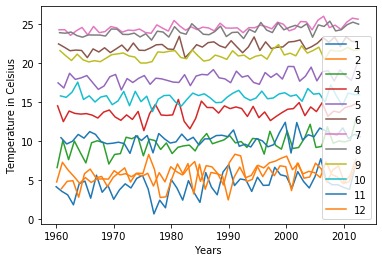

<Figure size 432x288 with 0 Axes>

In [4]:
mainControl = WorldController()

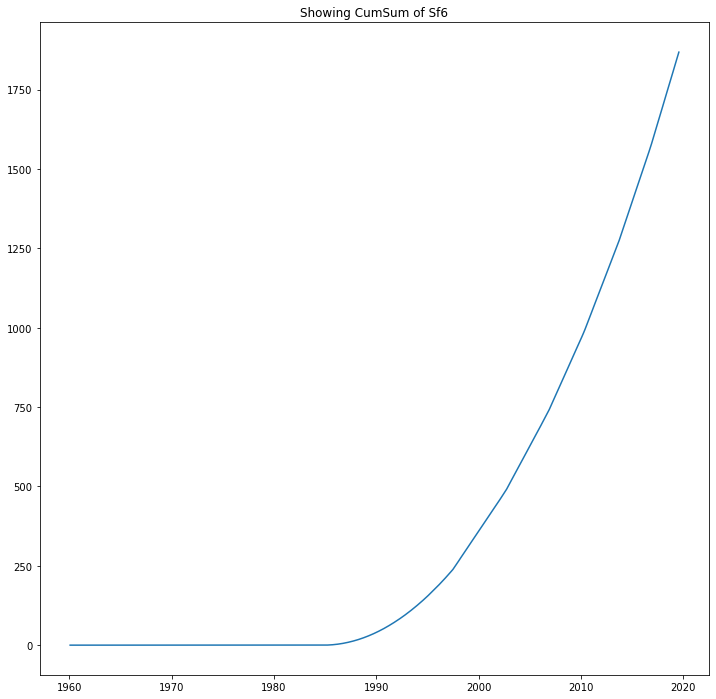

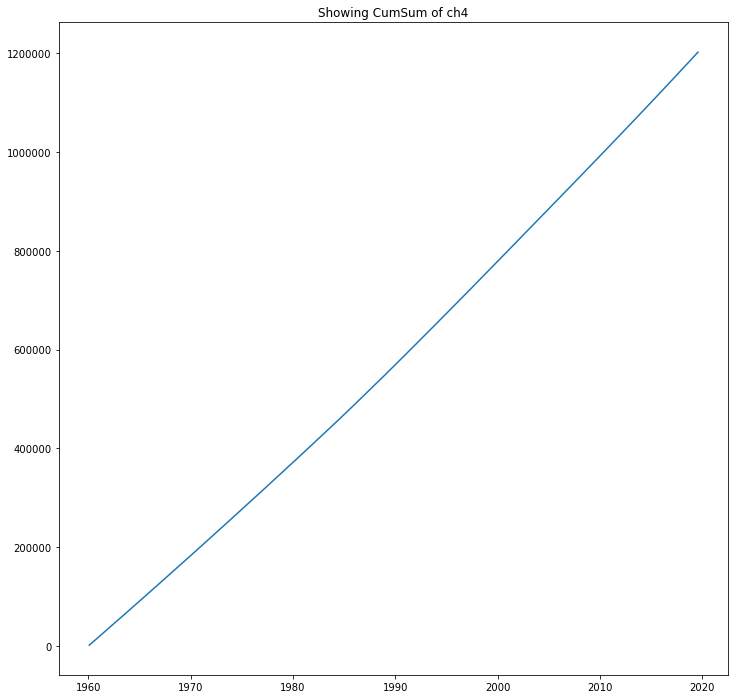

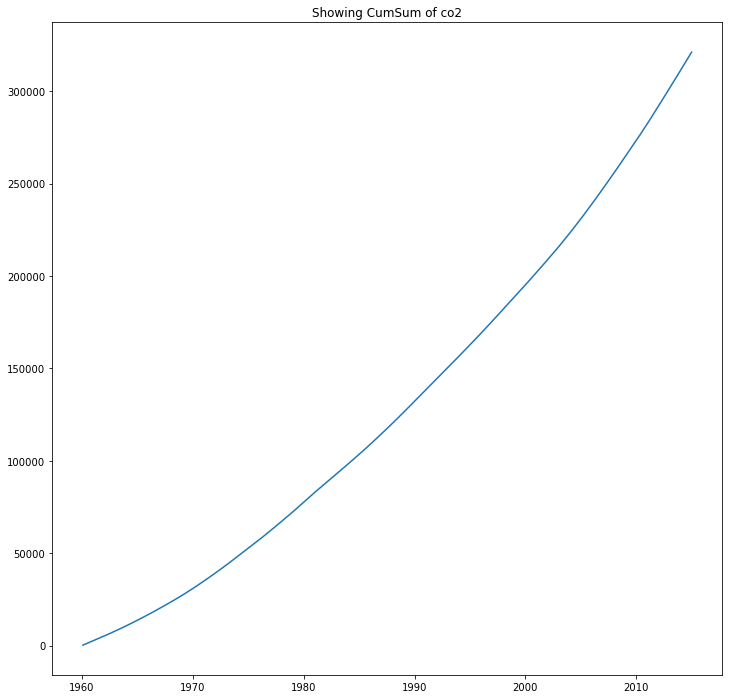

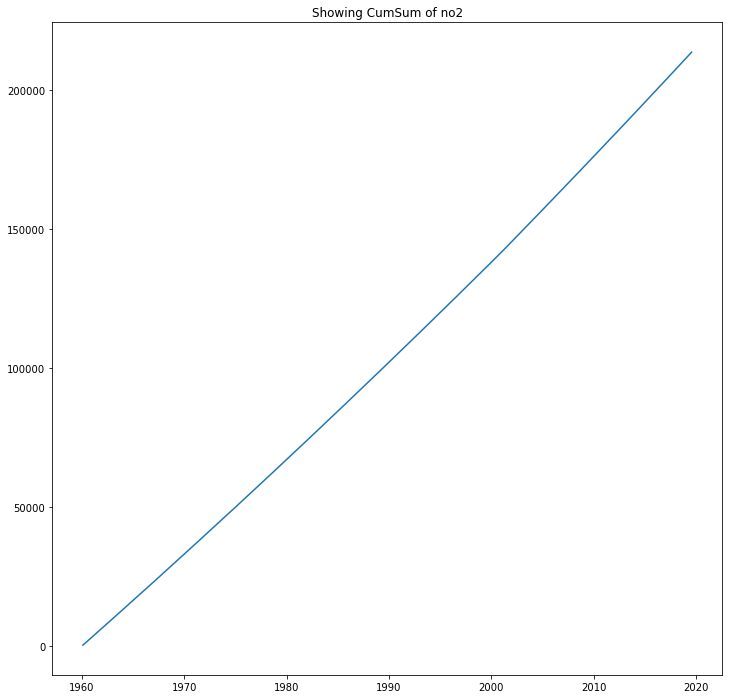

In [5]:
plt.figure(figsize=(12,12))
plt.plot(sf6_obj.monthDataFrame)
plt.title('Showing CumSum of Sf6')
plt.show()
plt.figure(figsize=(12,12))
plt.plot(CH4_obj.monthDataFrame)
plt.title('Showing CumSum of ch4')
plt.show()
plt.figure(figsize=(12,12))
plt.plot(co2_obj.monthDataFrame)
plt.title('Showing CumSum of co2')
plt.show()
plt.figure(figsize=(12,12))
plt.plot(n2o_obj.monthDataFrame)
plt.title('Showing CumSum of no2')
plt.show()

In [6]:
arrayOfDataToTrain = mainControl.getDfToTrain(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2012], n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2012], co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <=2012], CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2012])
    
#now we have an array with dataframes for each month, return several models.  One for each month.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

So something went wrong, before we move on, we are going to check the correlation of the data we currently have.  Next step is to try and gather more data that can be used for weather predictions.

In [7]:



arrayOfDataToTrain[0].corr()[['AverageTemperature']].sort_values('AverageTemperature')


AverageTemperature
Latitude                     -0.821355
Longitude                    -0.331798
sf6                           0.063202
co2                           0.080170
n2o                           0.080203
ch4                           0.080403
AverageTemperature            1.000000

Below shows visual representation of the correlation that was calculated from above.  

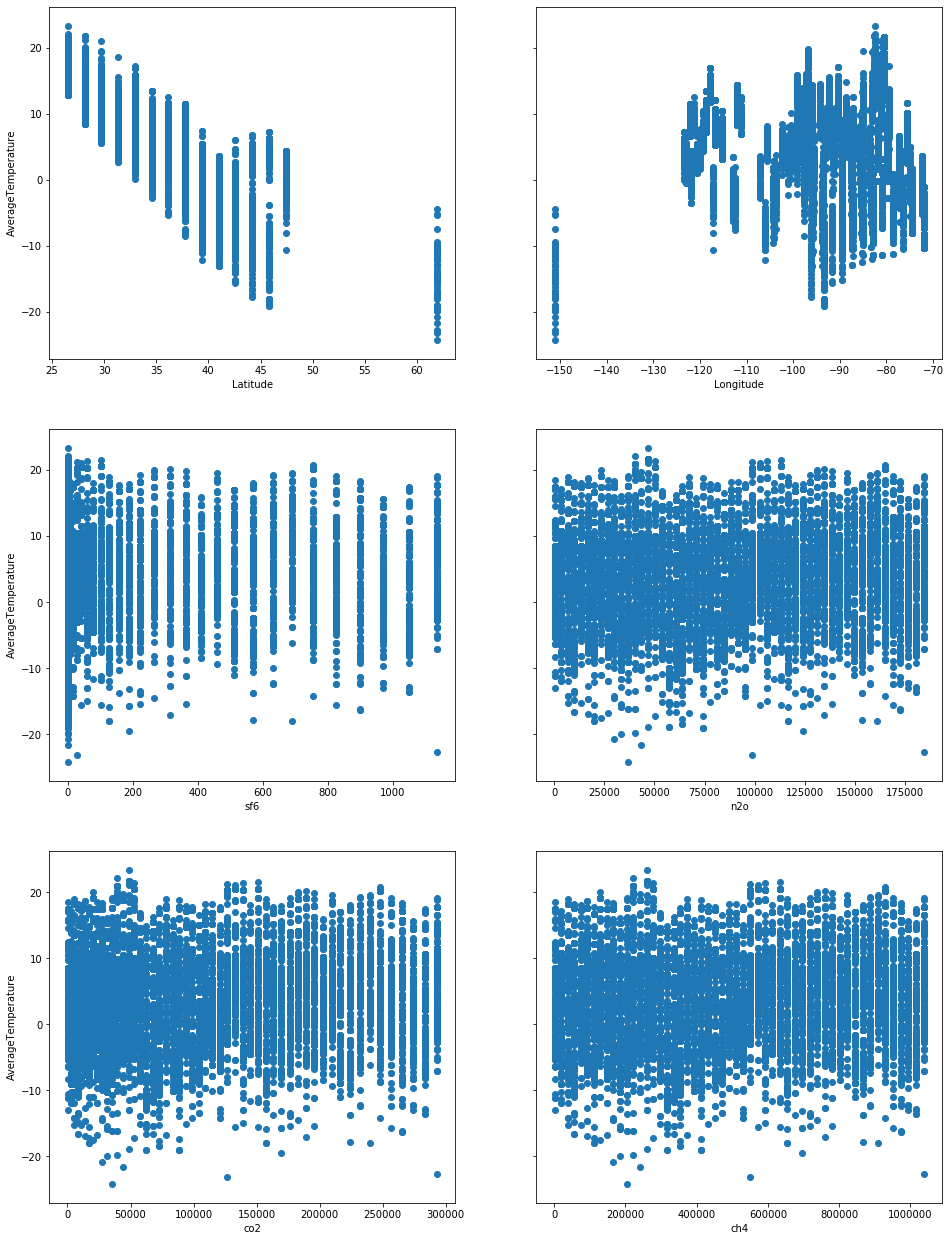

In [8]:
predictors = arrayOfDataToTrain[0].columns[1:].to_list()

df2 = arrayOfDataToTrain[0][['AverageTemperature'] + predictors]
#print(arrayOfDataToTrain[0].Longitude)
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(3, 2)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['AverageTemperature'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='AverageTemperature')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

Because latitude had the best correlation to weather, we will cluster all our data with latitude being the labels.  If we try to us latitude and longitude as columns when predicting, the values wouldn't mean anything.  

[3]


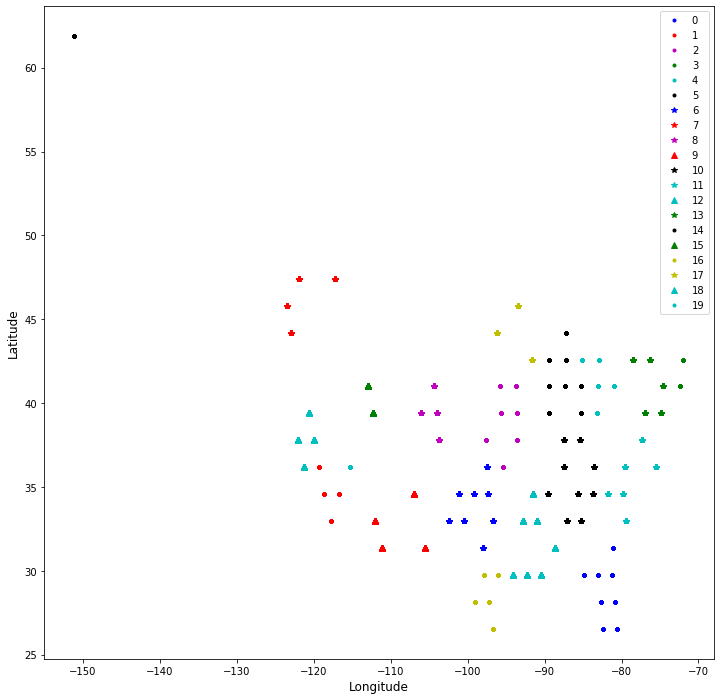

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [237]:
#from geohash2 import encode
#for df in arrayOfDataToTrain:
#    for index, row in df.iterrows():
#        print(encode(row['Latitude'],row['Longitude'], precision=2))

#datafile = cbook.get_sample_data('E:\OneDrive - University of Georgia\Data Science\project\usa.jpg')
#img = imread("E:/OneDrive - University of Georgia/Data Science/project/usa.jpg")

from sklearn.cluster import KMeans
id_n= 20
j = 0 
for df in arrayOfDataToTrain:
    X = df.loc[:, ['Longitude', 'Latitude']]
    #kmeans = KMeans(n_clusters=id_n, random_state=0).fit(np.array(X.loc[:,'Latitude'].to_list()).reshape(-1,1))
    # to kmeans by long and LAT and specify less neighbors.
    kmeans = KMeans(n_clusters=id_n, random_state=0).fit(np.array(X.loc[:,['Latitude', 'Longitude']]))
    #kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
    ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^', 'k*', 'c*', 'c^', 'g*', 'k.', 'g^', 'y.', 'y*','c^', 'c.'])
    myArray = np.zeros(len(kmeans.labels_))
    print(kmeans.predict(np.array([42, -72]).reshape(1,-1)))
    df['LongLat'] = kmeans.labels_
    id_label = kmeans.labels_
    if j == 0:
        plt.figure(figsize=(12,12))
        plt.ylabel('Latitude', fontsize=12)
        plt.xlabel('Longitude', fontsize=12)
        from sklearn.externals import joblib 
        fName = './KMeansModel/KMeansModel.pkl'
        joblib.dump(kmeans, open(fName, 'wb'))
        arrayOfClusters = []
        for i in range(id_n):
        
            cluster=np.where(id_label==i)[0]
            plt.plot(X.Longitude[cluster].values,X.Latitude[cluster].values ,ptsymb[i], label=i)
        plt.legend()
        plt.show()
    j+=1


Average: -182.30123698846586


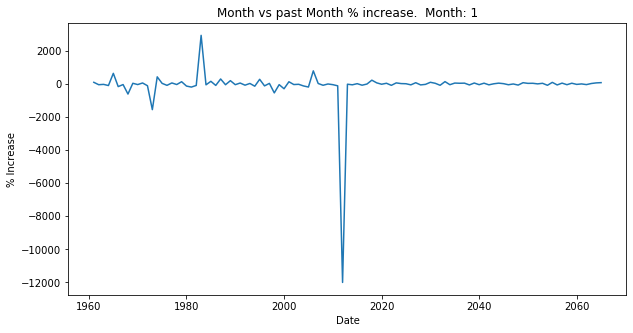

Average: -9.232221879468396


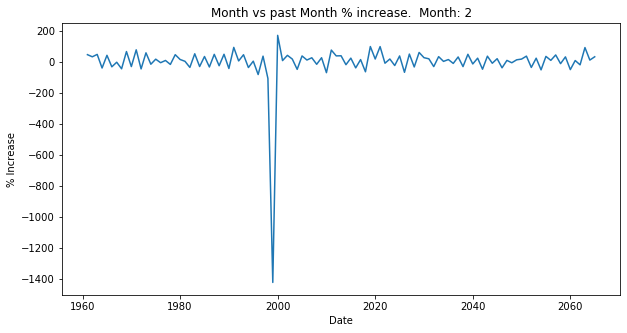

Average: 9.354584841673256


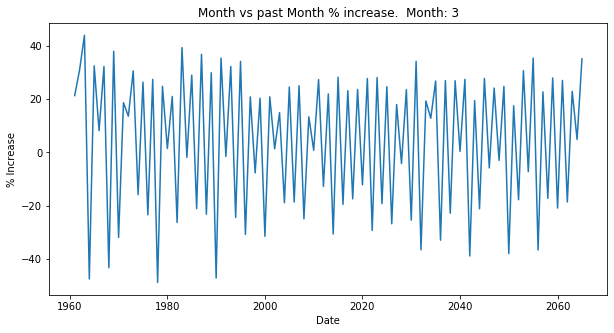

Average: 3.8071833332415745


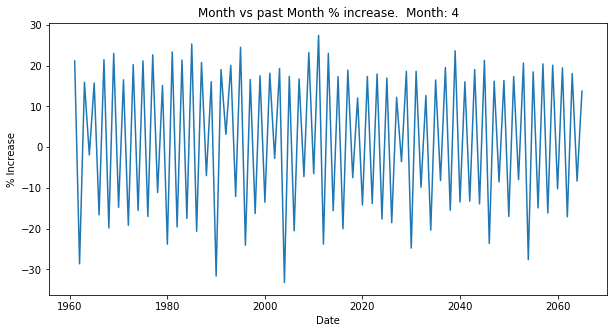

Average: 2.198399612612991


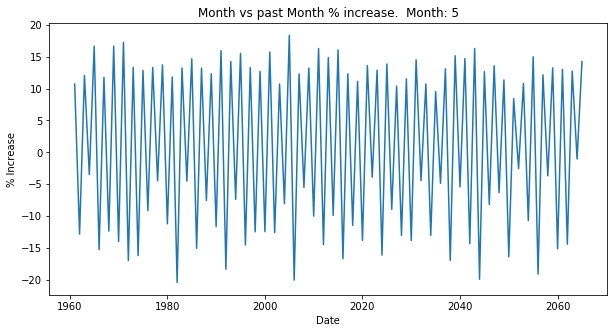

Average: 1.31585201690072


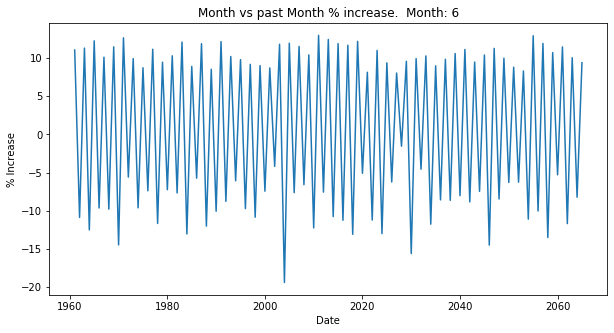

Average: 1.0909183923228374


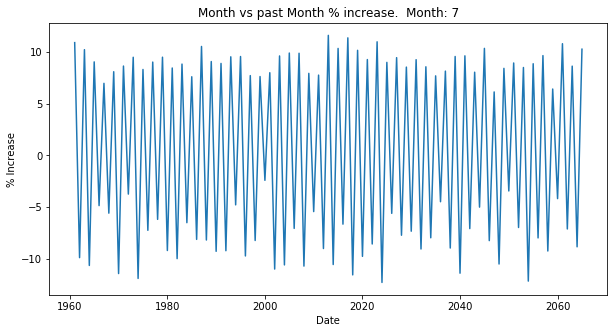

Average: 1.1039099715467644


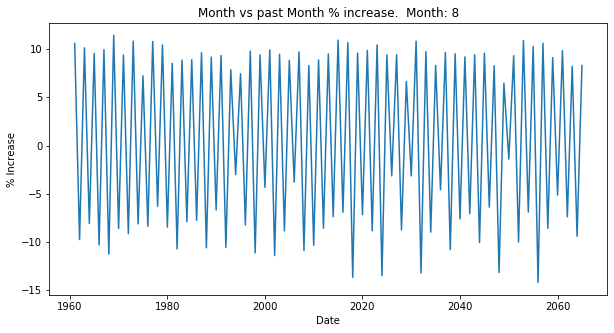

Average: 1.3466514514366317


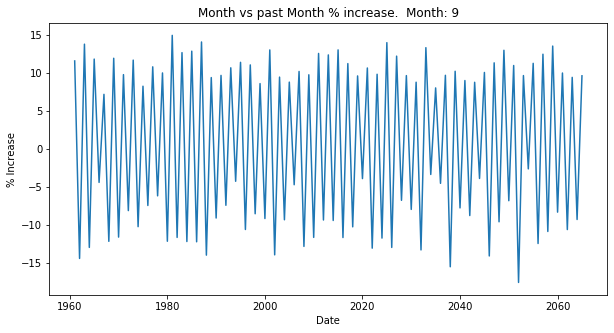

Average: 2.467872535746086


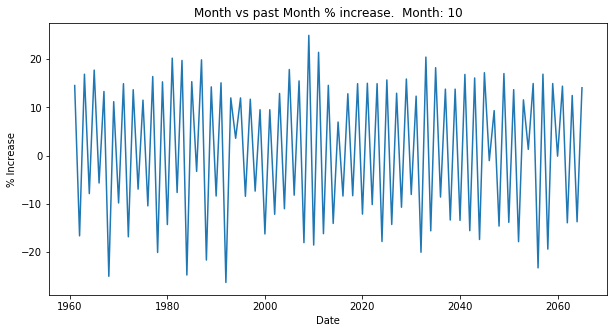

Average: 6.783598789146973


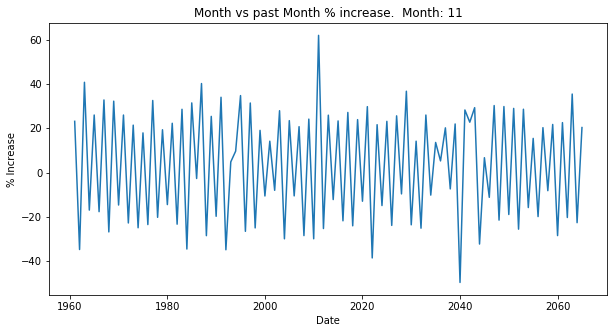

Average: 517.1652428108389


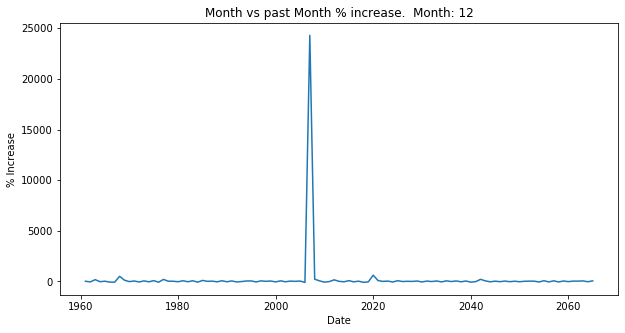

In [10]:


for keys in mainControl.getMonthDict().keys():

    df = mainControl.getMonthDict()[keys]
    df = df.reset_index()
    df['LongLat'] = arrayOfDataToTrain[0]['LongLat']
    df = df.groupby(by=['dt','LongLat']).agg('mean')['AverageTemperature']
    mtpy = []
    s = []
    for x in df:
        s.append(x)
        if len(s) == 10:
            mtpy.append(sum(s)/10)
            s = []
    print('Average: {}'.format(sum(IPA(mtpy))/52))
    plt.figure(figsize=(10,5))
    plt.plot([1961 + x for x in range(105)], IPA(mtpy))
    plt.title('Month vs past Month % increase.  Month: {}'.format(keys))
    plt.ylabel('% Increase')
    plt.xlabel('Date')
    plt.show()

So, predicting temperature with greenhouse gases may not have been the best idea.  So let us try to use the data we do have by predicting how climate change will change.  

<Figure size 720x720 with 0 Axes>

<Figure size 360x360 with 0 Axes>

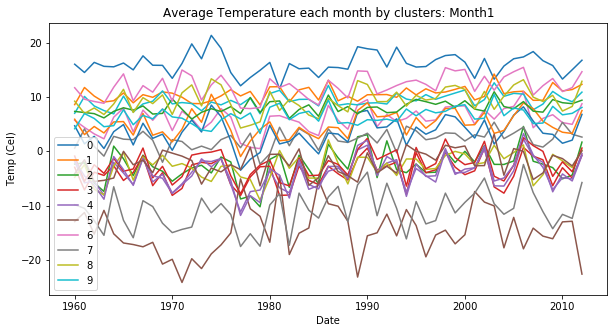

<Figure size 360x360 with 0 Axes>

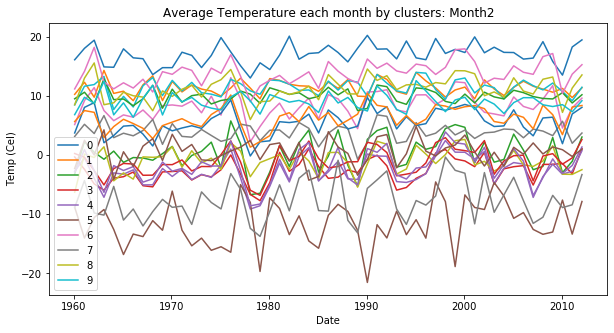

<Figure size 360x360 with 0 Axes>

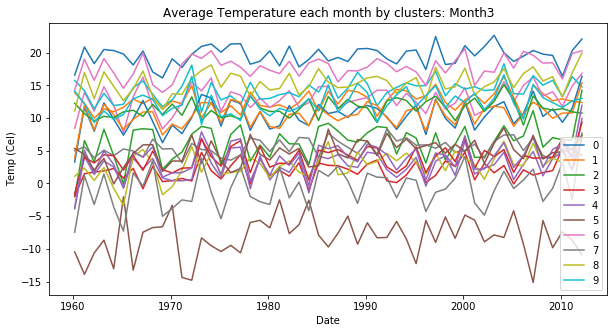

<Figure size 360x360 with 0 Axes>

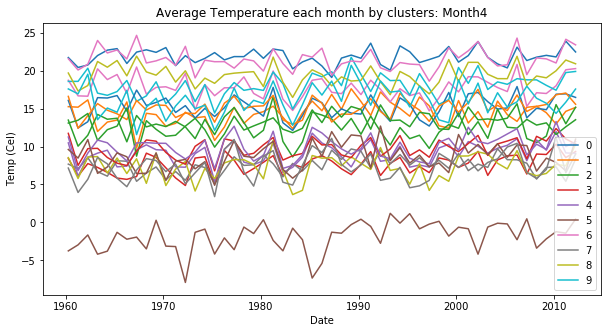

<Figure size 360x360 with 0 Axes>

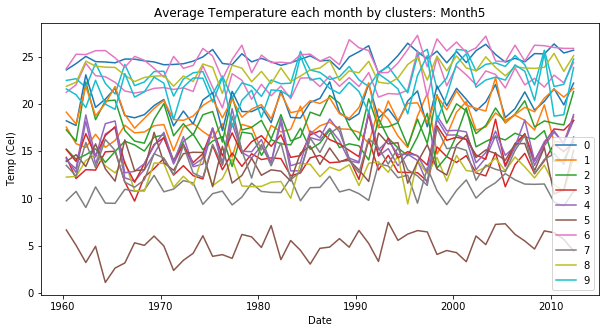

<Figure size 360x360 with 0 Axes>

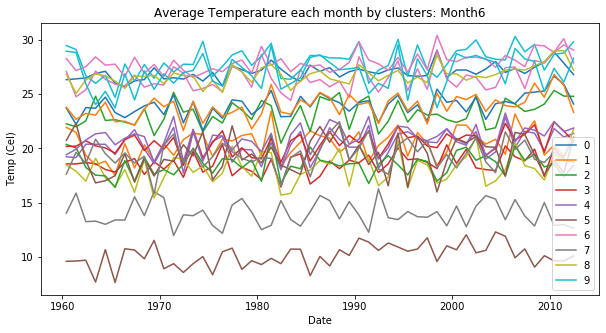

<Figure size 360x360 with 0 Axes>

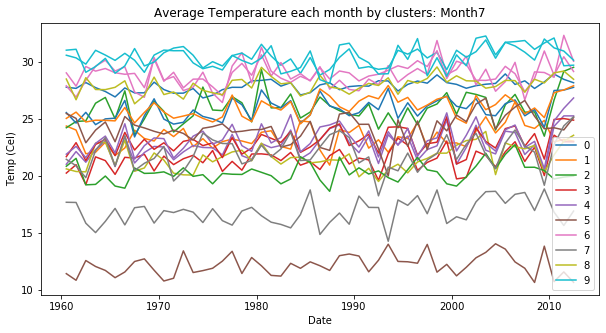

<Figure size 360x360 with 0 Axes>

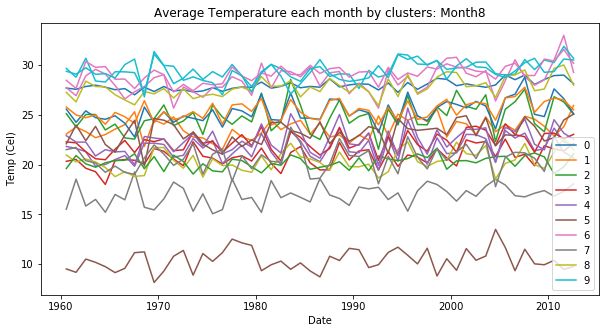

<Figure size 360x360 with 0 Axes>

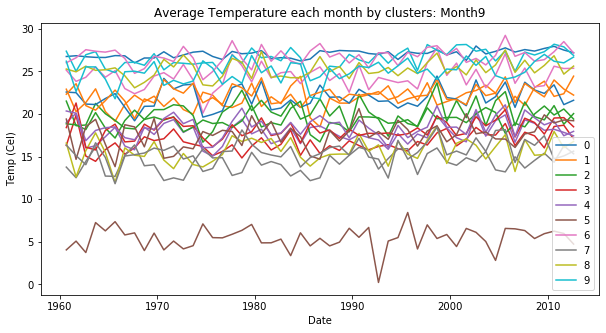

<Figure size 360x360 with 0 Axes>

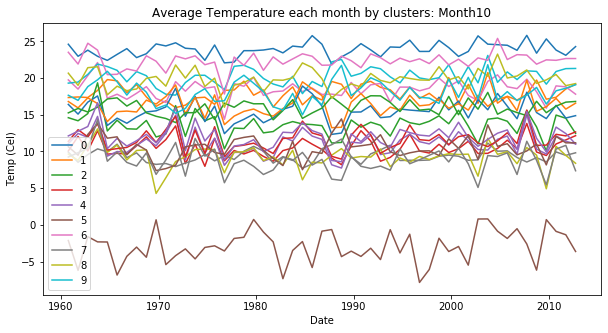

<Figure size 360x360 with 0 Axes>

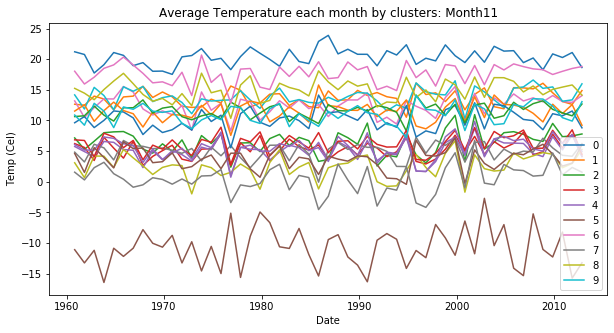

<Figure size 360x360 with 0 Axes>

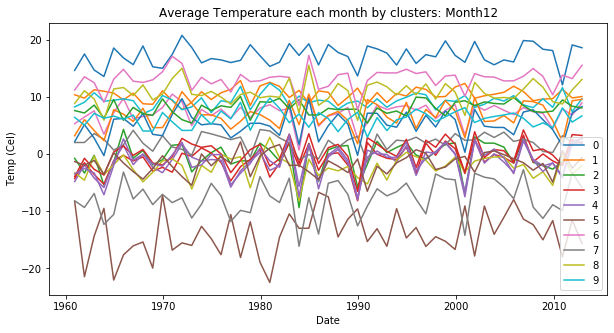

In [11]:
mainControl.getMonthDict()
import seaborn as sns
plt.figure(figsize=(10,10))
for keys in mainControl.getMonthDict().keys():
    plt.figure(figsize=(5,5))
    df = mainControl.getMonthDict()[keys]
    df = df.reset_index()
    df['LongLat'] = arrayOfDataToTrain[0]['LongLat']
    df = df.groupby(by=['dt','LongLat']).agg('mean')['AverageTemperature']

    plt.figure(figsize=(10,5))
    plt.xlabel('Date')
    plt.ylabel('Temp (Cel)')
    plt.title('Average Temperature each month by clusters: Month{}'.format(keys))
    for i in range(len(df.unstack(level=1).columns)):
        sns.lineplot(data=df.unstack(level=1)[i])
    plt.legend(range(10))
    plt.show()
    

While we have the data, might as well try out a MLP 

In [12]:
monthData = arrayOfDataToTrain.copy()
for i in range(len(monthData)):
    monthData[i] = monthData[i].drop(columns=['Longitude','Latitude'])


In [13]:
def MSE(actual, pred):
    size = len(actual)
    value = np.sum( (actual - pred)**2)
    return value / size 

I want to create a graph of time with the values that the predictor creates and the actual values, so we are creating another dataFrame completely filled, but the datetime is still intact to use as index. 

In [14]:
dateData = mainControl.getDfToTrain(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2012], n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2012], co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <=2012], CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2012], False)


In [15]:
from sklearn.neural_network import MLPRegressor
MLPModel1 = []
i = 1
for df in monthData:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    mlpMod = MLPRegressor(max_iter=500, random_state=21).fit(X_train, y_train)
    MLPModel1.append(mlpMod)
    print('Month: {}, R^2 Score: {}'.format(i,mlpMod.score(X_test,y_test)))
    #mlpMod.predict(X_test)
    #print(X_test)
    print('MSE {}'.format(MSE(y_test, mlpMod.predict(X_test))))
    #df['Predicted_Temp'] = linMod.predict(X_test)
    i+=1


Month: 1, R^2 Score: -6.515679997924822
MSE 402.0686230933105
Month: 2, R^2 Score: -17.190792663144244
MSE 890.4697847337897
Month: 3, R^2 Score: -16.83859463783204
MSE 627.653985334213
Month: 4, R^2 Score: -21.98284205208676
MSE 537.750997895939
Month: 5, R^2 Score: -23.119302099280016
MSE 453.617727434161
Month: 6, R^2 Score: -26.04878821958747
MSE 455.1075072045923
Month: 7, R^2 Score: -39.05985779920106
MSE 603.4537296590963
Month: 8, R^2 Score: -35.95540179422473
MSE 551.1928913774208
Month: 9, R^2 Score: -27.36135325256406
MSE 476.8235191757554
Month: 10, R^2 Score: -37.97975142020227
MSE 876.9788037810471
Month: 11, R^2 Score: -11.53477219733178
MSE 378.36179365860227
Month: 12, R^2 Score: -6.636232590288219
MSE 330.8062661429765


Now using new greenhouse gases, let us predict how the temperature is in Georgia for years 2012 to 2014.

In [16]:
sf6_test = sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year>2012 ]
sf6_test = sf6_test[sf6_test.index.year<=2014 ]
ch4_test = CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year>2012]
ch4_test = ch4_test[ch4_test.index.year<=2014 ]
co2_test = co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year>2012]
co2_test = co2_test[co2_test.index.year<=2014]
n2o_test = n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year>2012]
n2o_test = n2o_test[n2o_test.index.year<=2014]

LongLat = arrayOfDataToTrain[0]['LongLat'].unique()

allTest = pd.concat([sf6_test, n2o_test, co2_test, ch4_test], axis=1)
#dateData = mainControl.getDfToTrain(False)
myData = dateData.copy()
for i in range(len(monthData)):
    myData[i] = myData[i].drop(columns=['Longitude','Latitude'])
for i in range(len(monthData)):
    myData[i]['LongLat'] = monthData[i]['LongLat']


            sf6            n2o            co2           ch4  LongLat
0   1219.571698  188168.271191  302405.035616  1.058858e+06        7
1   1226.571698  188493.271191  303154.745205  1.060672e+06        7
2   1233.571698  188818.271191  303984.780822  1.062485e+06        7
3   1240.571698  189143.271191  304788.041096  1.064297e+06        7
4   1247.571698  189468.271191  305618.076712  1.066108e+06        7
5   1254.571698  189793.271191  306421.336986  1.067916e+06        7
6   1261.571698  190119.271191  307251.372603  1.069721e+06        7
7   1268.571698  190445.271191  308081.408219  1.071529e+06        7
8   1275.571698  190771.271191  308884.668493  1.073343e+06        7
9   1283.571698  191097.271191  309714.704110  1.075161e+06        7
10  1291.571698  191423.271191  310517.964384  1.076981e+06        7
11  1299.571698  191749.271191  311348.000000  1.078800e+06        7
12  1307.571698  192075.271191  312185.000000  1.080616e+06        7
13  1315.571698  192401.271191  31

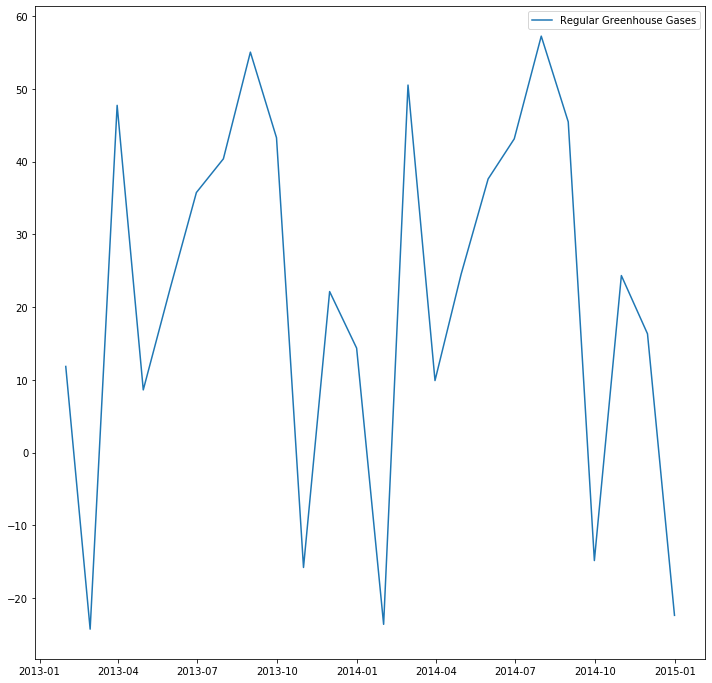

In [17]:


allTest = pd.concat([sf6_test, n2o_test, co2_test, ch4_test], axis=1)
allTest1 = allTest.reset_index(drop=True)
allTest1.columns=['sf6', 'n2o', 'co2', 'ch4']
allTest1['LongLat'] = [7] *  n2o_test.size
i = 0
print(allTest1)
predicted = []
predictedSkewedDouble = []
for index,row  in allTest1.iterrows():
    otherRow = np.append(np.array(row[0:4] * 2), (np.array(row[4])))
    #predictedSkewedDouble.append(MLPModel1[i].predict(otherRow.reshape(1,-1)))
        
    predicted.append(MLPModel1[i].predict(np.array(row).reshape(1,-1)))
    i+=1
    if i == 11:
        i=0
plt.figure(figsize=(12,12))
plt.plot(allTest.index, predicted,  label='Regular Greenhouse Gases')
#plt.plot(allTest.index, predictedSkewedDouble, label='Skewed 2* Greenhouse')
plt.legend()
plt.show()
#for model in MLPModel1:
#    print(model.predict(allTest))

Produce results for linear regression.  

In [18]:
linearRegressionArray = []
from sklearn.linear_model import LinearRegression
i = 1
listPredicted = []
listY = []
listX = []
listActual = []
for df in monthData:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    linModel = LinearRegression()
    linModel.fit(X_train, y_train)
    linearRegressionArray.append(linModel)
    print('Month: {}, R^2 Score: {}'.format(i,linModel.score(X_test,y_test)))
    listPredicted.append(linModel.predict(X_test))
    listActual.append(y_test)
    listX.append(X_train)
    listY.append(y_train)
    print('MSE {}'.format(MSE(y_test, linModel.predict(X_test))))
    i+=1

Month: 1, R^2 Score: 0.06741369813875608
MSE 49.89085357659788
Month: 2, R^2 Score: 0.04924698277725992
MSE 46.54095345150277
Month: 3, R^2 Score: 0.03217765318543009
MSE 34.05299382639602
Month: 4, R^2 Score: 0.006235568185606888
MSE 23.252033567935488
Month: 5, R^2 Score: 0.0035229858094487643
MSE 18.74099162392387
Month: 6, R^2 Score: 0.013421786720839157
MSE 16.599603193413866
Month: 7, R^2 Score: 0.009906260522850263
MSE 14.914575153871953
Month: 8, R^2 Score: 0.0075969775326759645
MSE 14.801773619220668
Month: 9, R^2 Score: 0.007924412645055834
MSE 16.67921021392632
Month: 10, R^2 Score: 0.027715601498773834
MSE 21.87476260535259
Month: 11, R^2 Score: 0.04772427579456673
MSE 28.744419555116338
Month: 12, R^2 Score: 0.0592899933660349
MSE 40.75213282708182


Now using new greenhouse gases, let us predict how the temperature is in Georgia for years 2012 to 2014.

[array([4.96055867]), array([6.03781663]), array([11.43632398]), array([14.75430754]), array([18.88976287]), array([22.99081513]), array([25.48059586]), array([24.77037811]), array([21.67083259]), array([15.84600388]), array([11.29471403]), array([4.83977845]), array([5.91214834]), array([11.52809048]), array([14.83213227]), array([18.89997738]), array([23.0297586]), array([25.52580787]), array([24.76668598]), array([21.67519311]), array([15.80715095]), array([11.32377896]), array([4.70470423]), array([5.76238202])]


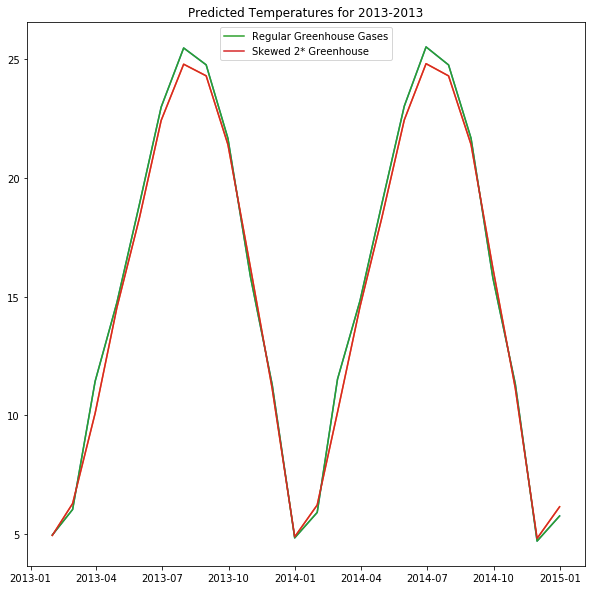

In [19]:
i = 0
predictedSkewedDouble = []
predicted = []
for index,row  in allTest1.iterrows():
    otherRow = np.append(np.array(row[0:4] /2 ), (np.array(row[4])))
    predictedSkewedDouble.append(linearRegressionArray[i].predict(otherRow.reshape(1,-1)))
    predicted.append(linearRegressionArray[i].predict(np.array(row).reshape(1,-1)))
    
    i+=1
    if i == 11:
        i=0
print(predicted)
plt.figure(figsize=(10,10))
plt.plot(allTest.index, predicted)
plt.plot(allTest.index, predictedSkewedDouble)
plt.plot(allTest.index, predicted,  label='Regular Greenhouse Gases')
plt.plot(allTest.index, predictedSkewedDouble, label='Skewed 2* Greenhouse')
plt.title('Predicted Temperatures for 2013-2013')
plt.legend()
plt.show()

So Linear Regression is the best bet for this when looking at the graphs.  How about when we use bagging regression? 


In [20]:
bagModel = []
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

for df in monthData:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    regr = BaggingRegressor(base_estimator=SVR(gamma='auto'), n_estimators=10, random_state=0).fit(x, y)
    bagModel.append(regr)


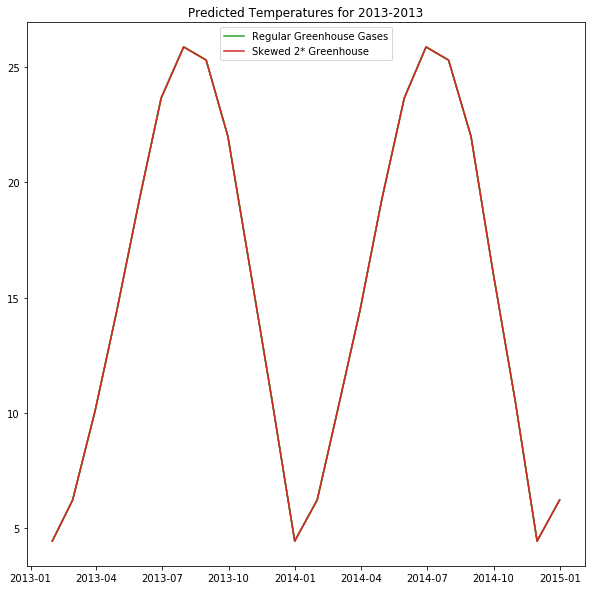

In [21]:
i = 0

predictedSkewedDouble = []
predicted = []
for index,row  in allTest1.iterrows():
    otherRow = np.append(np.array(row[0:4] /7  ), (np.array(row[4])))
    predictedSkewedDouble.append(bagModel[i].predict(otherRow.reshape(1,-1)))
    predicted.append(bagModel[i].predict(np.array(row).reshape(1,-1)))
    
    i+=1
    if i == 11:
        i=0

plt.figure(figsize=(10,10))
plt.plot(allTest.index, predicted)
plt.plot(allTest.index, predictedSkewedDouble)
plt.plot(allTest.index, predicted,  label='Regular Greenhouse Gases')
plt.plot(allTest.index, predictedSkewedDouble, label='Skewed 2* Greenhouse')
plt.title('Predicted Temperatures for 2013-2013')
plt.legend()
plt.show()

So with the bagging regression, we have a good model.  However it does not predict anything if the values are greater than what it has seen.  And we want it to for it to be used in a simulator.  

Last comparison of our actual and predicted values.

Saving the LinearModels to be used.  

In [24]:
from sklearn.externals import joblib 
import calendar as cal
i = 0
for model in linearRegressionArray:
    fName = './learnedLinModelsByMonth/{}GHLinModel'.format(cal.month_abbr[i+1])
    joblib.dump(model, '{}.pkl'.format(fName)) 
    #pickle.dump(model, open(fName, 'wb'))
    i+=1

In [25]:
#just a test.  Average temperature 
print(linearRegressionArray[0].predict(np.array([0,0,0,0,0]).reshape(1,-1)))
print('actual average was 6.3777778, 3 units wrong.  Which for the purpose of this, is descent')

[7.10357556]
actual average was 6.3777778, 3 units wrong.  Which for the purpose of this, is descent


## Simulation preperation

The Kmeans model has been saved for us to use for our simulation.  The simulation will start from 1960 and end at 2012 and have varying greenhouse gas levels based on some sort of rate.  For us to continue with this experiment, I will have to construct a polynomaial for the greenhouse gases to be able to be used within the simulation to create realistic data.  Using the data, I can check the rate of change for each gas and store that infromation to be used as baseline values for the simulation.  

In [26]:
# Caclulate rates for each month and store.  
#sf6Rate = (sf6_obj.monthDataFrame['average'].sub(sf6_obj.monthDataFrame['average'].shift())) / np.abs(sf6_obj.monthDataFrame['average']) 
#sf6Rate.iloc[0] = 0
#sf6Rate.to_csv(path_or_buf ='./greenhouseRates/sf6Rates',header= 'rate', index_label='dt' )

for greenhouseObj in [sf6_obj, CH4_obj, co2_obj, n2o_obj]:
    try: 
        otherGr = greenhouseObj.monthDataFrame.rename(columns={'average':'rate'})
        rate = (otherGr['rate']).sub(otherGr['rate'].shift()) / np.abs(otherGr['rate'].shift())  
        rate.iloc[0] = 0
        rate.to_csv(path_or_buf ='./greenhouseRates/{}Rates.csv'.format(greenhouseObj.dataName),header= 'rate', index_label='dt' )            
    except KeyError:
        otherGr = greenhouseObj.monthDataFrame.rename(columns={'CarbonEmissions':'rate'})
        rate = (otherGr['rate'].sub(otherGr['rate'].shift())) / np.abs(otherGr['rate'].shift())  
        rate.iloc[0] = 0
        rate.to_csv(path_or_buf ='./greenhouseRates/{}Rates.csv'.format(greenhouseObj.dataName),header= 'rate', index_label='dt' ) 

So that we can compare to actual temperature of our clustered data, we need to make another dataframe with index intact, and then add the kmeans classifier to it. Below we try to use a MPL Model, and Linear Regression Model with this testing.  

In [239]:
from sklearn import linear_model
linearRegressionClusters = dict()
for x in range(0,12):
    linearRegressionClusters[x] = {}
for key in linearRegressionClusters.keys():
    for x in range(0,20):
        linearRegressionClusters[key][x] = None

i = 0
listPredicted = []
listY = []
listX = []
listClusterName = []
listActual = []
# so first month is january...
# 
for df in monthData:
    for name, value in df.groupby(['LongLat']):
        x =  value[value.columns[1:-1]]
        y = value[value.columns[0]]
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
        linModel = linear_model.BayesianRidge()
        linModel.fit(X_train, y_train)
        linearRegressionClusters[i][name] = linModel
        listPredicted.append(linModel.predict(X_test))
        listX.append(X_train)
        listY.append(y_train)
        listClusterName.append(name)

    i+=1

In [241]:
i = 0
for key in linearRegressionClusters.keys():
    dirName = './learnedBayLinModelByClusters/{}'.format(cal.month_abbr[i+1])
    for aKey in linearRegressionClusters[key]:
        fName = "{}/{}linModel".format(dirName,aKey)
        joblib.dump(linearRegressionClusters[key][aKey], '{}.pkl'.format(fName)) 
    i+=1

./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/0linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/1linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/2linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/3linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/4linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/5linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/6linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/7linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/8linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/9linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/10linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinModelByClusters/Jan/11linModel
./learnedBayLinModelByClusters/Jan./learnedBayLinM

In [187]:
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy import stats
#listX. listY
for i in range(len(listX)) :
    X2 = sm.add_constant(listX[i])
    est = sm.OLS(listY[i], X2)
    est2 = est.fit()
    print("####CLUSTER: {}####".format(listClusterName[i]))
    print(est2.summary())

####CLUSTER: 0####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5364
Date:                Wed, 11 Dec 2019   Prob (F-statistic):              0.709
Time:                        22:11:17   Log-Likelihood:                -451.01
No. Observations:                 180   AIC:                             912.0
Df Residuals:                     175   BIC:                             928.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8739      1.000 

####CLUSTER: 7####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.1488
Date:                Wed, 11 Dec 2019   Prob (F-statistic):              0.963
Time:                        22:11:18   Log-Likelihood:                -187.45
No. Observations:                  84   AIC:                             384.9
Df Residuals:                      79   BIC:                             397.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3675      0.790 

strong multicollinearity or other numerical problems.
####CLUSTER: 15####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     3.414
Date:                Wed, 11 Dec 2019   Prob (F-statistic):             0.0179
Time:                        22:11:18   Log-Likelihood:                -71.275
No. Observations:                  42   AIC:                             152.5
Df Residuals:                      37   BIC:                             161.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

####CLUSTER: 1####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     8.711
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           8.97e-07
Time:                        22:11:18   Log-Likelihood:                -944.10
No. Observations:                 445   AIC:                             1898.
Df Residuals:                     440   BIC:                             1919.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0792      0.391 

strong multicollinearity or other numerical problems.
####CLUSTER: 9####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.157
Date:                Wed, 11 Dec 2019   Prob (F-statistic):              0.333
Time:                        22:11:18   Log-Likelihood:                -325.45
No. Observations:                 127   AIC:                             660.9
Df Residuals:                     122   BIC:                             675.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

####CLUSTER: 16####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.083
Date:                Wed, 11 Dec 2019   Prob (F-statistic):             0.0908
Time:                        22:11:18   Log-Likelihood:                -125.15
No. Observations:                  84   AIC:                             260.3
Df Residuals:                      79   BIC:                             272.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.8257      0.401

####CLUSTER: 3####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.837
Date:                Wed, 11 Dec 2019   Prob (F-statistic):             0.0277
Time:                        22:11:19   Log-Likelihood:                -217.81
No. Observations:                 116   AIC:                             445.6
Df Residuals:                     111   BIC:                             459.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1947      0.579 

####CLUSTER: 11####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.607
Date:                Wed, 11 Dec 2019   Prob (F-statistic):             0.0379
Time:                        22:11:19   Log-Likelihood:                -364.76
No. Observations:                 159   AIC:                             739.5
Df Residuals:                     154   BIC:                             754.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9633      0.906

strong multicollinearity or other numerical problems.
####CLUSTER: 18####
                            OLS Regression Results                            
Dep. Variable:     AverageTemperature   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.2209
Date:                Wed, 11 Dec 2019   Prob (F-statistic):              0.926
Time:                        22:11:19   Log-Likelihood:                -225.87
No. Observations:                  95   AIC:                             461.7
Df Residuals:                      90   BIC:                             474.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

Here we do Linear Regression. and overwrite our test from MPL.

In [244]:
#SO i realize that having clusters doesnt help.  Instead, make each cluster have a model!! !

linearRegressionClusters = dict()
for x in range(0,12):
    linearRegressionClusters[x] = {}
for key in linearRegressionClusters.keys():
    for x in range(0,20):
        linearRegressionClusters[key][x] = None

i = 0
listPredicted = []
listY = []
listX = []
listActual = []
listClusterName = []
for df in monthData:
    for name, value in df.groupby(['LongLat']):
        #train each cluster and store in this...

        x =  value[value.columns[1:-1]]
        y = value[value.columns[0]]
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
        linModel = LinearRegression()
        linModel.fit(X_train, y_train)
        linearRegressionClusters[i][name] = linModel
        #print('Month: {}, R^2 Score: {}'.format(i,linModel.score(X_test,y_test)))
        listPredicted.append(linModel.predict(X_test))
        #listActual.append(y_test)
        listX.append(X_train)
        listY.append(y_train)
        listClusterName.append(name)
        #print('MSE {}'.format(MSE(y_test, linModel.predict(X_test))))
    i+=1

Now that we created A DICT with linear models for each cluster, for each month, we save it for the simulation.

In [245]:
i = 0
for key in linearRegressionClusters.keys():
    dirName = './learnedLinModelByClusters/{}'.format(cal.month_abbr[i+1])
    for aKey in linearRegressionClusters[key]:
        fName = "{}/{}linModel".format(dirName,aKey)
        joblib.dump(linearRegressionClusters[key][aKey], '{}.pkl'.format(fName)) 

    i+=1

In [46]:
dataWithDates = mainControl.getDfToTrain(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2014], n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2014], co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <=2014], CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2014], removeIndex=False)

The below saves the data for us to use

In [174]:
from sklearn.cluster import KMeans
id_n= 20
j = 0 
for df in dataWithDates:
    X = df.loc[:, ['Longitude', 'Latitude']]
    #kmeans = KMeans(n_clusters=id_n, random_state=0).fit(np.array(X.loc[:,'Latitude'].to_list()).reshape(-1,1))
    # to kmeans by long and LAT and specify less neighbors.
    kmeans = KMeans(n_clusters=id_n, random_state=0).fit(np.array(X.loc[:,['Latitude', 'Longitude']]))
    #kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
    ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^', 'k*', 'c*', 'c^', 'g*', 'k.', 'g^', 'y.', 'y*','c^', 'c.'])
    myArray = np.zeros(len(kmeans.labels_))
    
    df['LongLat'] = kmeans.labels_
    id_label = kmeans.labels_


In [200]:
i=0
for df in dataWithDates:
    dirName = './ActualClusterTemperatures/{}'.format(cal.month_abbr[i+1])
    for name, group in df.groupby(['LongLat']):
        myDict={'dt':group.index.unique().to_list(), 'average':group['AverageTemperature'].groupby('dt').mean().to_list()}
        #group['AverageTemperature'].mean()
        df = pd.DataFrame(myDict)
        fName = "{}/Cluster{}Temp.csv".format(dirName,name)
        df.to_csv(fName,  header=['dt', 'average'], index=False)
    #print(group['AverageTemperature'])
    i+=1

In [201]:
co2 = co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year<=2014]
co2 = co2.rename(columns={'CarbonEmissions':'average'})
sf6 = sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2014]
n2o = n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2014]
ch4 = CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2014]
sf6.to_csv("./ActualGreenHouseData/sf6Cumulative.csv",  header=['average'], index_label='dt')
co2.to_csv("./ActualGreenHouseData/co2Cumulative.csv",  header=['average'],index_label='dt')
n2o.to_csv("./ActualGreenHouseData/n2oCumulative.csv",  header=['average'], index_label='dt')
ch4.to_csv("./ActualGreenHouseData/ch4Cumulative.csv",  header=['average'], index_label='dt')

## Desicion Tree models
###  regular regressor

In [246]:
#SO i realize that having clusters doesnt help.  Instead, make each cluster have a model!! !
from sklearn import tree
linearRegressionClusters = dict()
for x in range(0,12):
    linearRegressionClusters[x] = {}
for key in linearRegressionClusters.keys():
    for x in range(0,20):
        linearRegressionClusters[key][x] = None

i = 0
listPredicted = []
listY = []
listX = []
listActual = []
listClusterName = []
for df in monthData:
    for name, value in df.groupby(['LongLat']):
        #train each cluster and store in this...
        x =  value[value.columns[1:-1]]
        y = value[value.columns[0]]
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
        linModel = tree.DecisionTreeRegressor()
        linModel.fit(X_train, y_train)
        linearRegressionClusters[i][name] = linModel
        #print('Month: {}, R^2 Score: {}'.format(i,linModel.score(X_test,y_test)))
        listPredicted.append(linModel.predict(X_test))
        #listActual.append(y_test)
        listX.append(X_train)
        listY.append(y_train)
        listClusterName.append(name)
        #print('MSE {}'.format(MSE(y_test, linModel.predict(X_test))))
    i+=1
    


In [247]:
i = 0
for month in linearRegressionClusters:
    dirName = './learnedTreeModelByClusters/{}'.format(cal.month_abbr[i+1])
    for key in linearRegressionClusters.keys():
        fName = "{}/{}linModel".format(dirName,key)
        joblib.dump(linearRegressionClusters[i][key], '{}.pkl'.format(fName)) 
    i+=1

 ### ensemble, random forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#SO i realize that having clusters doesnt help.  Instead, make each cluster have a model!! !
from sklearn import tree
linearRegressionClusters = dict()
for x in range(0,12):
    linearRegressionClusters[x] = {}
for key in linearRegressionClusters.keys():
    for x in range(0,20):
        linearRegressionClusters[key][x] = None

i = 0
listPredicted = []
listY = []
listX = []
listActual = []
listClusterName = []
for df in monthData:
    for name, value in df.groupby(['LongLat']):
        #train each cluster and store in this...
        x =  value[value.columns[1:-1]]
        y = value[value.columns[0]]
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
        linModel = RandomForestRegressor()
        linModel.fit(X_train, y_train)
        linearRegressionClusters[i][name] = linModel
        #print('Month: {}, R^2 Score: {}'.format(i,linModel.score(X_test,y_test)))
        listPredicted.append(linModel.predict(X_test))
        #listActual.append(y_test)
        listX.append(X_train)
        listY.append(y_train)
        listClusterName.append(name)
        #print('MSE {}'.format(MSE(y_test, linModel.predict(X_test))))
    i+=1

In [248]:
i = 0
for month in linearRegressionClusters:
    dirName = './learnedEnsembleModelByClusters/{}'.format(cal.month_abbr[i+1])
    for key in linearRegressionClusters.keys():
        fName = "{}/{}linModel".format(dirName,key)
        joblib.dump(linearRegressionClusters[i][key], '{}.pkl'.format(fName)) 
    i+=1

## Ada Boost Regressor

In [250]:
from sklearn.ensemble import AdaBoostRegressor
#SO i realize that having clusters doesnt help.  Instead, make each cluster have a model!! !
from sklearn import tree
linearRegressionClusters = dict()
for x in range(0,12):
    linearRegressionClusters[x] = {}
for key in linearRegressionClusters.keys():
    for x in range(0,20):
        linearRegressionClusters[key][x] = None

i = 0
listPredicted = []
listY = []
listX = []
listActual = []
listClusterName = []
for df in monthData:
    for name, value in df.groupby(['LongLat']):
        #train each cluster and store in this...
        x =  value[value.columns[1:-1]]
        y = value[value.columns[0]]
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
        linModel = AdaBoostRegressor()
        linModel.fit(X_train, y_train)
        linearRegressionClusters[i][name] = linModel
        #print('Month: {}, R^2 Score: {}'.format(i,linModel.score(X_test,y_test)))
        listPredicted.append(linModel.predict(X_test))
        #listActual.append(y_test)
        listX.append(X_train)
        listY.append(y_train)
        listClusterName.append(name)
        #print('MSE {}'.format(MSE(y_test, linModel.predict(X_test))))
    i+=1

In [251]:
i = 0
for month in linearRegressionClusters:
    dirName = './learnedAdaModelByClusters/{}'.format(cal.month_abbr[i+1])
    for key in linearRegressionClusters.keys():
        fName = "{}/{}linModel".format(dirName,key)
        joblib.dump(linearRegressionClusters[i][key], '{}.pkl'.format(fName)) 
    i+=1

## Conclusion
Using correlation, latitude is the best bet of predicting weather for a given year. The greenhouse gases do not hold much presence in terms of power. With each month having a p-value greater than .1, our anova test does not prove our hypothesis that greenhouse gases can predcit weather. There were many factors of concern when creating this model.

1) We could only get such limited free data about greenhouse gases. We had to parse, aggregate and make a linear prediction graph from 1980 to 1960 to fill in nan values for the greenhouses to be used in tangent with 1960 -1980 weather data.

2) Greenhouse gases are dependent on the greenhouse gases left there from prevous years however this is not accounted for, neither are greenhouse gas per capita so we could not calculate every humans footprint.

3) With Co2 data, this was extracted and could not be put into levels at time of data collection such as the other greenhouse gases were condensed to.

4) The data we did get were split into an average over months, as we were given year data. This may not be a big issue but it was apart of the process.

5) Climate factors should have been taken into consideration when building this model for us to predict weather better.



## Future

This project could be improved by the above factors. As well as being used when connected to a rasberry pi that gathers weather data in athens to continously update the learning model. The only issue here is that greenhouse gases would need to be captured as well or to find a data source that updates greenhouse gases on the regular.